# 1.0 Libraries

In [1]:
!pip install langid
!pip install gensim
!pip install -U spacy
!python -m spacy download it_core_news_sm
!wget https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
!tar -xzvf s2v_reddit_2015_md.tar.gz
!pip install sense2vec
!pip install spacy_fastlang

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=294a44fba8a651b7e7df7271feeee4c0583e4c8d29b2744ad706b82b81bb7bca
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
--2024-04-04 20:38:46--  https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting

In [2]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

import re
import json
import gensim.downloader as api

import langid
from gensim.models import Word2Vec
import spacy
import spacy_fastlang

from sense2vec import Sense2Vec
import random

import torch
from transformers import RobertaTokenizer
from transformers import RobertaForMultipleChoice
from torch.distributions import Categorical
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import time
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/gdrive


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 2.0 Set up

In [3]:
def load_data(data_path, gold_path):
  hypernyms_dict = {}
  with open(data_path, "r", encoding = 'utf-8') as data_file, open(gold_path, "r", encoding = 'utf-8') as gold_file:
    for data_line, gold_line in zip(data_file, gold_file):
      term_list = [term for term in data_line.split()[:-1]]
      term = " ".join(term_list)
      hypernyms = [hypernym.replace("\n", "") for hypernym in gold_line.split("\t")]
      hypernyms_dict[term] = hypernyms
  return hypernyms_dict

In [4]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/MNLP - HW1 - task 26/SemEval2018-Task9/SemEval2018-Task9/{split}/data/1B.italian.{split}.data.txt"
gold_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/MNLP - HW1 - task 26/SemEval2018-Task9/SemEval2018-Task9/{split}/gold/1B.italian.{split}.gold.txt"

# italian training data
train_data_path = data_path.format(split = 'training')
train_gold_path = gold_path.format(split = 'training')
train_hypernyms = load_data(train_data_path, train_gold_path)

# italian test data
test_data_path = data_path.format(split = 'test')
test_gold_path = gold_path.format(split = 'test')
test_hypernyms = load_data(test_data_path, test_gold_path)

In [5]:
# NLP pipeline to process italian language
nlp = spacy.load("it_core_news_sm")
nlp.add_pipe("language_detector")

In [6]:
def load_vocabulary(vocabulary_path):
  with open(vocabulary_path, "r", encoding = 'utf-8') as vocabulary_file:
    vocabulary = vocabulary_file.read().splitlines()
  return vocabulary


# OLD VERSION: ineffective
# def detect_language(word):
#   language, confidence = langid.classify(word)
#   return language


def detect_language(word):
  doc = nlp(word)
  language = doc._.language
  return language


def clean_vocabulary(vocabulary):
  new_vocabulary = []
  for word in vocabulary:
    if word.isalpha(): # filter out numeric terms
      #language, confidence = langid.classify(word)
      language = detect_language(word)
      if language == 'it': # filter out non-italian words
        new_vocabulary.append(word)
  return new_vocabulary

In [7]:
# italian vocabulary
vocabulary_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/MNLP - HW1 - task 26/SemEval2018-Task9/SemEval2018-Task9/vocabulary/1B.italian.vocabulary.txt"
vocabulary = load_vocabulary(vocabulary_path)
print("Number of terms in the vocabulary: ", len(vocabulary), "\n")

# filtered italian vocabulary
vocabulary = clean_vocabulary(vocabulary)
for sublist_train, sublist_test in zip(train_hypernyms.values(), test_hypernyms.values()):
  vocabulary.extend(sublist_train)
  vocabulary.extend(sublist_test)

vocabulary = list(set(vocabulary)) # to avoid duplicates
print("Number of terms in the filtered vocabulary: ", len(vocabulary), "\n")
vocabulary[:20] # preview of the first 20 terms

Number of terms in the vocabulary:  79715 

Number of terms in the filtered vocabulary:  22970 



['orago',
 'montevettolini',
 'decriptazione',
 'idrolisi',
 'pianerottolo',
 'autoformazione',
 'sotterrare',
 'perentoriamente',
 'paradossalmente',
 'massicciata',
 'supposizione',
 'malevolenza',
 'appellante',
 'ammortizzazione',
 'topazio',
 'cucinino',
 'virgola',
 'incasinare',
 'diverticolosi',
 'pietrisco']

# 3.0 Create entries

In [8]:
# word2vec model using existing vocabulary
sentences = [vocabulary]
w2v_model = Word2Vec(sentences, min_count=1)

In [ ]:
# sense2vec model
s2v_model = Sense2Vec().from_disk('./s2v_old')

In [ ]:
sense = s2v_model.get_best_sense("gatto")
s2v_model.most_similar(sense, n=5)

[('frutto|NOUN', 0.8995),
 ('sapore|NOUN', 0.899),
 ('biglietto|NOUN', 0.8961),
 ('integrazione|NOUN', 0.8921),
 ('addosso|NOUN', 0.8905)]

In [9]:
def find_distractors(hypernym, data, term, num_distractors):
  # sense = s2v_model.get_best_sense(hypernym)
  # if sense:
  #   distractors = s2v_model.most_similar(sense, n=5)
  #   filtered_distractors = [distractor[0].split("|")[0].replace("_", " ") for distractor in distractors if distractor[0].split("|")[0].replace("_", " ") not in data[term]]
  #   return filtered_distractors[:num_distractors]
  # else:
  distractors = w2v_model.wv.most_similar(hypernym, topn = 5)
  filtered_distractors = [distractor[0] for distractor in distractors if distractor[0] not in data[term]]
  return filtered_distractors[:num_distractors]

def save_jsonl(file_path, data):
  id_seq = 0
  with open(file_path, "w") as output_file:
    for term, hypernyms in data.items():
      for hypernym in hypernyms:
        distractors = find_distractors(hypernym, data, term, num_distractors = 3)
        entries = (hypernym, *distractors)
        choices = list(entries)
        random.shuffle(choices) # to create randomness
        reformatted_json_data = {
              'id' : id_seq,
              'text': term,
              'choices': choices,
              'label' : choices.index(hypernym)
        }
        json.dump(reformatted_json_data, output_file)
        output_file.write("\n")
        id_seq +=1

def read_lines_jsonl(file_path, num_lines):
  with open(file_path, 'r') as f:
    json_list = list(f)
    for line in json_list[:num_lines]:
      data = json.loads(line)
      print(data)

In [10]:
# train jsonl file
save_jsonl("hypernym_discovery-task26-train-data.jsonl", train_hypernyms)
read_lines_jsonl("hypernym_discovery-task26-train-data.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'text': 'sesto', 'choices': ['lungaggine', 'colonna', 'atletico', 'grado'], 'label': 3}
{'id': 1, 'text': 'sesto', 'choices': ['evirazione', 'numero ordinale', 'apatico', 'piantare'], 'label': 1}
{'id': 2, 'text': 'sesto', 'choices': ['introspettiva', 'primolo', 'tempio', 'frazione'], 'label': 3}
{'id': 3, 'text': 'sesto', 'choices': ['sfibrare', 'carica', 'arrivo', 'forzosamente'], 'label': 1}
{'id': 4, 'text': 'Sigillo', 'choices': ['orgasmico', 'sterile', 'sonetto', 'comune'], 'label': 3}
{'id': 5, 'text': 'Sigillo', 'choices': ['filibustiere', 'distico', 'micronauti', 'municipalità'], 'label': 3}
{'id': 6, 'text': 'Sigillo', 'choices': ['panetto', 'soffitta', 'comune italiano', 'destrutturazione'], 'label': 2}
{'id': 7, 'text': 'Sigillo', 'choices': ['frazione', 'tempio', 'primolo', 'introspettiva'], 'label': 0}
{'id': 8, 'text': 'Sigillo', 'choices': ['polmonare', 'proseguimento', 'paese', 'borgonato'], 'label': 2}
{'id': 9, 'text': 'Sigillo', 'choices': ['lattemiele', '

In [11]:
# test jsonl file
save_jsonl("hypernym_discovery-task26-test-data.jsonl", test_hypernyms)
read_lines_jsonl("hypernym_discovery-task26-test-data.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'text': 'tecnologia', 'choices': ['striscio', 'disciplina', 'falsamente', 'ambulante'], 'label': 1}
{'id': 1, 'text': 'tecnologia', 'choices': ['guidatore', 'voltaggio', 'incerato', 'produzione'], 'label': 3}
{'id': 2, 'text': 'tecnologia', 'choices': ['conclusivo', 'anaerobicamente', 'scienza', 'premeditare'], 'label': 2}
{'id': 3, 'text': 'schermata', 'choices': ['whispers', 'immagine', 'personaggio immaginario', 'dimentica'], 'label': 1}
{'id': 4, 'text': 'schermata', 'choices': ['esenzione', 'sabbione', 'illustrazione', 'misone'], 'label': 2}
{'id': 5, 'text': 'schermata', 'choices': ['pallavolo', 'riproduzione', 'volteggio', 'robbiate'], 'label': 1}
{'id': 6, 'text': 'schermata', 'choices': ['stracciatura', 'rappresentazione', 'micotossine', 'puccio'], 'label': 1}
{'id': 7, 'text': 'schermata', 'choices': ['deossiribonucleico', 'nascenza', 'raffigurazione', 'marzio'], 'label': 2}
{'id': 8, 'text': 'schermata', 'choices': ['diabetologia', 'bistrò', 'maccarello', 'proiezio

# 4.0 Prompt formulation

In [12]:
prompts = [
    "Il termine '{text}' può essere iperonimo di: \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}",
    "Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}",
    "Scegli l'iperonimo del termine '{text}': \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"
]

In [13]:
print(' '.join(prompt + '\n\n' for prompt in prompts), end='')

Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}

 Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}

 Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}



In [14]:
def save_prompts_jsonl(prompts, file_path):
  json_prompts = []
  for prompt in prompts:
    json_prompts.append({"prompt": prompt})

  with open(file_path, "w") as output_file:
    for json_prompt in json_prompts:
      json.dump(json_prompt, output_file)
      output_file.write("\n")

In [15]:
save_prompts_jsonl(prompts, "hypernym_discovery-task26-json.jsonl")
read_lines_jsonl("hypernym_discovery-task26-json.jsonl", num_lines = 3)

{'prompt': "Il termine '{text}' può essere iperonimo di: \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}
{'prompt': "Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}
{'prompt': "Scegli l'iperonimo del termine '{text}': \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}


# 5.0 Prompts Evaluation

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [81]:
def evaluate_prompt(tokenizer, model, prompt, data_file, zero_shot_classification = False):
  formatted_prompts, y_true, y_pred, score = [], [], [], []
  lines = 0

  with open(data_file, "r") as f:
    json_data = list(f)
    for line in json_data:
      pair = json.loads(line)
      id = pair['id']
      text = pair['text']
      choices = pair['choices']
      label = pair['label']

      formatted_prompt = prompt.format(text = text, option1 = choices[0], option2 = choices[1], option3 = choices[2], option4 = choices[3])
      inputs = tokenizer([formatted_prompt] * len(choices), choices,
                         padding = True, return_tensors = "pt").to(device)

      if zero_shot_classification:
        output = model(inputs, candidate_labels=choices, hypothesis_template="Questo esempio è {}.")
        predicted_output = output['labels'][0]
        predicted_label = choices.index(predicted_output)
        prediction_score = output['scores'][0]
        lines += 1

        if lines == 300:
          break

      else:
        labels = torch.tensor(len(choices) - 1).unsqueeze(0)
        with torch.no_grad():
          output = model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels = labels)

        probabilities = torch.softmax(output["logits"][0], -1).tolist()
        predicted_label = np.argmax(probabilities)
        prediction_score = probabilities[predicted_label]
        lines += 1

        if lines == 300:
          break

      formatted_prompts.append(formatted_prompt)
      y_true.append(label)
      y_pred.append(predicted_label)
      score.append(prediction_score)

    return formatted_prompts, y_true, y_pred, score


def visualize_results(results, num_results):
  for prompt in range(len(results)):
    for n in range(num_results):
      print("Prompt: ", results[prompt][0][n])
      print("True label: ", results[prompt][1][n])
      print("Predicted label: ", results[prompt][2][n])
      print("Prediction score: ", round(results[prompt][3][n], 3))
      print(" ")

In [82]:
def compute_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
  recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
  f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
  cf_matrix = confusion_matrix(y_true, y_pred)
  return accuracy, precision, recall, f1, cf_matrix


def print_confusion_matrix(metrics, type):
  for n in range(len(metrics)):
    print(f"{type} Confusion Matrix for the Prompt {n}")
    print("Prompt: ", prompts[n])

    # Confusion Matrix Plot
    cf_matrix = metrics[n][4]
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(cf_matrix, annot = True, fmt = '.0f')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

    print("Total Predictions: ", np.sum(cf_matrix))
    print("Correct Predictions: ", np.trace(cf_matrix))
    print("----------------------------------------------------------------")
    print(" ")

def print_overall_statistics(train_metrics, test_metrics, prompts):
  comparison_table = []
  for id, prompt in enumerate(prompts):
    data = {}
    for dtype, metrics in zip(['Train', 'Test'], [train_metrics, test_metrics]):
      accuracy, precision, recall, f1, cf_matrix = metrics[id]
      data[f'{dtype} Accuracy'] = round(accuracy, 3)
      data[f'{dtype} Precision'] = round(precision, 3)
      data[f'{dtype} Recall'] = round(recall, 3)
      data[f'{dtype} F1-score'] = round(f1, 3)
    comparison_table.append(data)
  return pd.DataFrame(comparison_table).transpose()

## 5.1 RoBERTa For Multiple Choice

In [83]:
model_name = "LIAMF-USP/roberta-large-finetuned-race"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = RobertaForMultipleChoice.from_pretrained(model_name).to(device)

In [84]:
start_time = time.time()
roberta_train_results, roberta_test_results = [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(roberta_tokenizer, roberta_model, prompt, "hypernym_discovery-task26-train-data.jsonl")
  roberta_train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(roberta_tokenizer, roberta_model, prompt, "hypernym_discovery-task26-test-data.jsonl")
  roberta_test_results.append([formatted_prompt, y_true, y_pred, score])

end_time = time.time()
print("Execution Time: ", (end_time - start_time)/60, "minutes")

Execution Time:  1.9569334228833517 minutes


In [85]:
visualize_results(roberta_train_results, num_results = 2) # preview of the first 2 train results for each prompt

Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) lungaggine 
 b) colonna 
 c) atletico 
 d) grado
True label:  3
Predicted label:  0
Prediction score:  0.833
 
Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) evirazione 
 b) numero ordinale 
 c) apatico 
 d) piantare
True label:  1
Predicted label:  0
Prediction score:  0.838
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) lungaggine 
 b) colonna 
 c) atletico 
 d) grado
True label:  3
Predicted label:  0
Prediction score:  0.779
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) evirazione 
 b) numero ordinale 
 c) apatico 
 d) piantare
True label:  1
Predicted label:  0
Prediction score:  0.555
 
Prompt:  Scegli l'iperonimo del termine 'sesto': 
 a) lungaggine 
 b) colonna 
 c) atletico 
 d) grado
True label:  3
Predicted label:  0
Prediction score:  0.716
 
Prompt:  Scegli l'iperonimo del termine 'sesto': 
 a) evirazione 
 b) numero or

In [86]:
roberta_train_metrics, roberta_test_metrics = [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(roberta_train_results[prompt][1], roberta_train_results[prompt][2])
  roberta_train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(roberta_test_results[prompt][1], roberta_test_results[prompt][2])
  roberta_test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

### Overall Statistics

Train Confusion Matrix for the Prompt 0
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


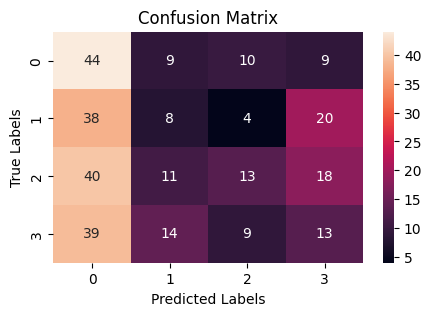

Total Predictions:  299
Correct Predictions:  78
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 1
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


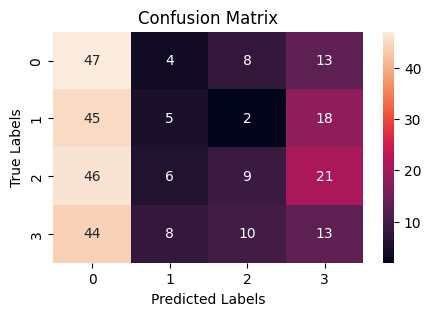

Total Predictions:  299
Correct Predictions:  74
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 2
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


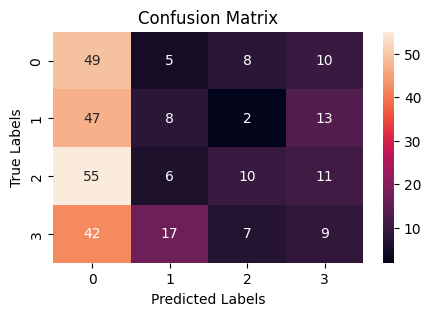

Total Predictions:  299
Correct Predictions:  76
----------------------------------------------------------------
 


In [87]:
# Train Statistics for each prompt
print_confusion_matrix(roberta_train_metrics, "Train")

Test Confusion Matrix for the Prompt 0
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


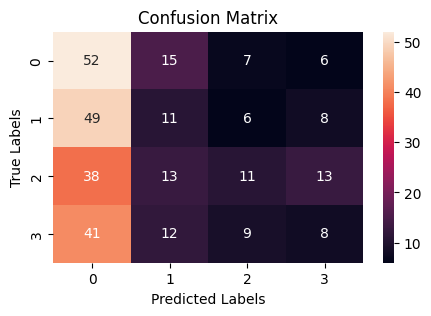

Total Predictions:  299
Correct Predictions:  82
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 1
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


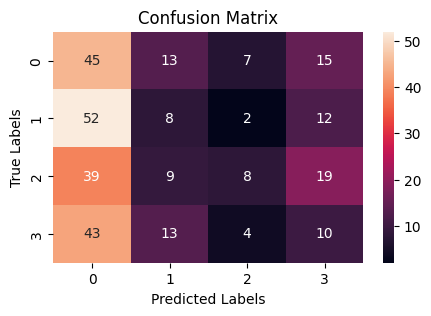

Total Predictions:  299
Correct Predictions:  71
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 2
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


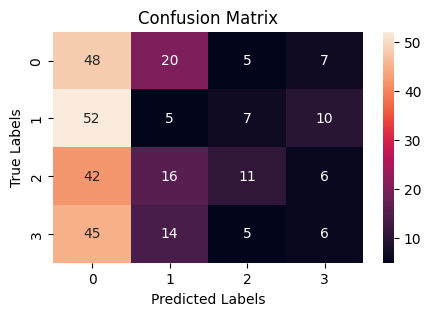

Total Predictions:  299
Correct Predictions:  70
----------------------------------------------------------------
 


In [88]:
# Test Statistics for each prompt
print_confusion_matrix(roberta_test_metrics, "Test")

In [89]:
print_overall_statistics(roberta_train_metrics, roberta_test_metrics, prompts)

,0,1,2
Train Accuracy,0.261,0.247,0.254
Train Precision,0.264,0.248,0.267
Train Recall,0.261,0.247,0.254
Train F1-score,0.233,0.205,0.213
Test Accuracy,0.274,0.237,0.234
Test Precision,0.268,0.251,0.238
Test Recall,0.274,0.237,0.234
Test F1-score,0.237,0.206,0.197


## 5.2 Zero Shot Text Classification

In [90]:
classifier_names = ["xlm-roberta-large", "facebook/bart-large-mnli"]
#roberta_classifier = pipeline("zero-shot-classification", model=classifier_names[0], batch_size = 8, truncation=True, device = device)

bert_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
bert_classifier = pipeline("zero-shot-classification", model=classifier_names[1], batch_size = 8, truncation=True, device = device)

In [91]:
start_time = time.time()
classifier_train_results, classifier_test_results = [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(bert_tokenizer, roberta_classifier, prompt, "hypernym_discovery-task26-train-data.jsonl", True)
  classifier_train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(bert_tokenizer, roberta_classifier, prompt, "hypernym_discovery-task26-test-data.jsonl", True)
  classifier_test_results.append([formatted_prompt, y_true, y_pred, score])

end_time = time.time()
print("Execution Time: ", (end_time - start_time)/60, "minutes")

Execution Time:  0.9809847831726074 minutes


In [92]:
visualize_results(classifier_train_results, num_results = 2) # preview of the first 2 train results for each prompt

Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) lungaggine 
 b) colonna 
 c) atletico 
 d) grado
True label:  3
Predicted label:  2
Prediction score:  0.25
 
Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) evirazione 
 b) numero ordinale 
 c) apatico 
 d) piantare
True label:  1
Predicted label:  3
Prediction score:  0.251
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) lungaggine 
 b) colonna 
 c) atletico 
 d) grado
True label:  3
Predicted label:  2
Prediction score:  0.25
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) evirazione 
 b) numero ordinale 
 c) apatico 
 d) piantare
True label:  1
Predicted label:  3
Prediction score:  0.251
 
Prompt:  Scegli l'iperonimo del termine 'sesto': 
 a) lungaggine 
 b) colonna 
 c) atletico 
 d) grado
True label:  3
Predicted label:  2
Prediction score:  0.25
 
Prompt:  Scegli l'iperonimo del termine 'sesto': 
 a) evirazione 
 b) numero ordin

In [93]:
classifier_train_metrics, classifier_test_metrics = [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(classifier_train_results[prompt][1], classifier_train_results[prompt][2])
  classifier_train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(classifier_test_results[prompt][1], classifier_test_results[prompt][2])
  classifier_test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

### Overall Statistics

Train Confusion Matrix for the Prompt 0
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


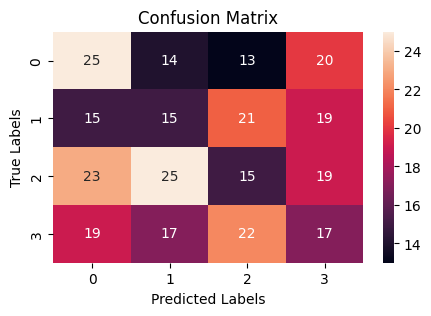

Total Predictions:  299
Correct Predictions:  72
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 1
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


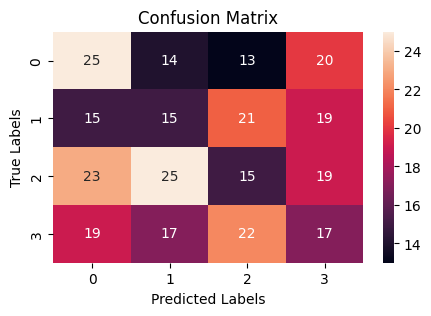

Total Predictions:  299
Correct Predictions:  72
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 2
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


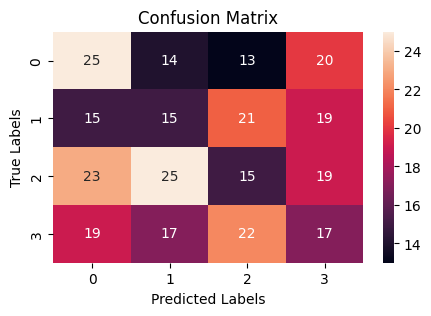

Total Predictions:  299
Correct Predictions:  72
----------------------------------------------------------------
 


In [94]:
# Train Confusion Matrix for each prompt
print_confusion_matrix(classifier_train_metrics, "Train")

Test Confusion Matrix for the Prompt 0
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


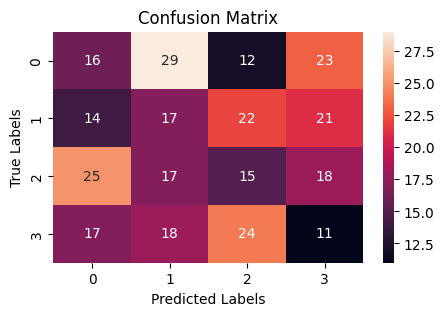

Total Predictions:  299
Correct Predictions:  59
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 1
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


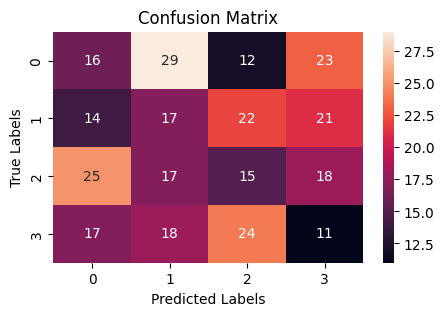

Total Predictions:  299
Correct Predictions:  59
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 2
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


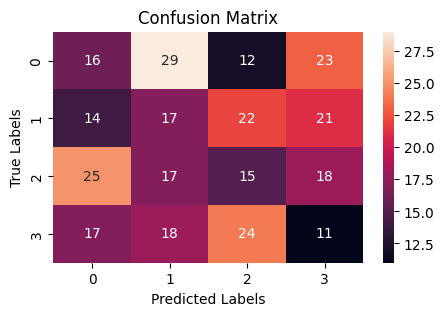

Total Predictions:  299
Correct Predictions:  59
----------------------------------------------------------------
 


In [95]:
# Test Statistics for each prompt
print_confusion_matrix(classifier_test_metrics, "Test")

In [96]:
print_overall_statistics(classifier_train_metrics, classifier_test_metrics, prompts)

,0,1,2
Train Accuracy,0.241,0.241,0.241
Train Precision,0.238,0.238,0.238
Train Recall,0.241,0.241,0.241
Train F1-score,0.239,0.239,0.239
Test Accuracy,0.197,0.197,0.197
Test Precision,0.198,0.198,0.198
Test Recall,0.197,0.197,0.197
Test F1-score,0.197,0.197,0.197
